Chỉ số | Ý nghĩa | Khi nào dùng | Ghi chú
---|---|---|---
Silhouette Score | Đánh giá độ "gọn cụm" và "xa cụm khác" | Luôn dùng | Cao hơn thì tốt
Number of Clusters | Số lượng cụm được tạo ra | Luôn theo dõi |

# Khai báo thư viện

In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
# ------------------------------------------------------------------
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# ------------------------------------------------------------------
from scipy.stats import uniform
# ------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
# ------------------------------------------------------------------
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
# ------------------------------------------------------------------
from sklearn.metrics import silhouette_score, calinski_harabasz_score,davies_bouldin_score
from sklearn.metrics import make_scorer, silhouette_samples
# ------------------------------------------------------------------
from hyperopt import fmin, hp, tpe, Trials, STATUS_OK
from joblib import Parallel, delayed
import optuna
from optuna.pruners import MedianPruner

# Data

In [149]:
df = pd.read_csv("D:\_Dev\_Group Project\Affinity-Propagation-ML-UEH\Data\Mall Customers\Mall_Customers_preprocessed.csv")

In [150]:
df.head()

,customerid,age,annual_income,spending_score,genre_Female
0,1,-1.424569,-1.738999,-0.434801,0.0
1,2,-1.281035,-1.738999,1.195704,0.0
2,3,-1.352802,-1.700830,-1.715913,1.0
3,4,-1.137502,-1.700830,1.040418,1.0
4,5,-0.563369,-1.662660,-0.395980,1.0


In [151]:
data = df.drop(columns=["customerid"],axis=1,)

In [152]:
X = data.copy()
X.head()

,age,annual_income,spending_score,genre_Female
0,-1.424569,-1.738999,-0.434801,0.0
1,-1.281035,-1.738999,1.195704,0.0
2,-1.352802,-1.700830,-1.715913,1.0
3,-1.137502,-1.700830,1.040418,1.0
4,-0.563369,-1.662660,-0.395980,1.0


# Áp Dụng

## AP

### 1. Tham số thuật toán

```
preference
damping
```
=> Tập trung tối ưu vào damping và preference

In [167]:
ap = AffinityPropagation(random_state=42, damping=0.6, preference=-30.201)
ap.fit(X)

AffinityPropagation(damping=0.6, preference=-30.201, random_state=42)

### 2. Biểu diễn phân cụm

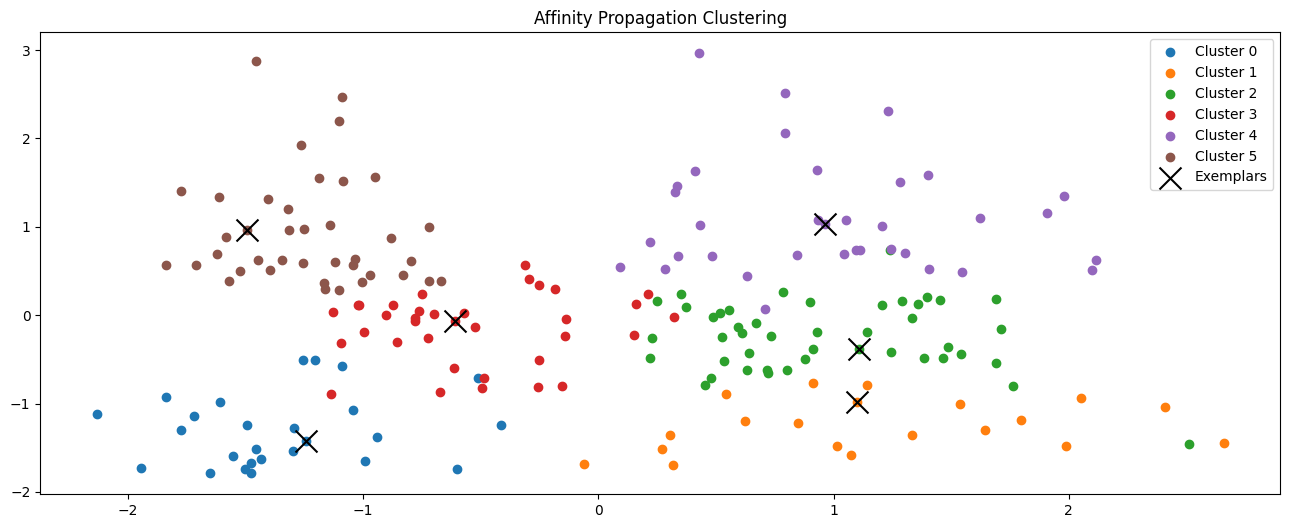

In [168]:
# Giảm số chiều về 2
X_2d = PCA(n_components=2).fit_transform(X)

labels = ap.labels_
exemplars = ap.cluster_centers_indices_

plt.figure(figsize=(16, 6))
for cluster in set(labels):
    plt.scatter(
        X_2d[labels == cluster, 0],
        X_2d[labels == cluster, 1],
        label=f"Cluster {cluster}",
    )
plt.scatter(
    X_2d[exemplars, 0],
    X_2d[exemplars, 1],
    c="black",
    marker="x",
    s=250,
    label="Exemplars",
    edgecolors="white",
)
plt.legend()
plt.title("Affinity Propagation Clustering")
plt.show()

# Hyperparameter Optimization

### 1. Grid Search

In [155]:
# Không gian tìm kiếm
param_grid = {
    "damping": np.linspace(0.5, 0.9, 5),
    "preference": np.linspace(-300, 0, 150),
}


grid = ParameterGrid(param_grid)

# Lưu trữ kết quả tốt nhất
top_results = []

for params in grid:
    model = AffinityPropagation(
        damping=params["damping"], preference=params["preference"], random_state=42
    )
    labels = model.fit_predict(X)
    n_clusters = len(set(labels))

    if n_clusters <= 1 or n_clusters >= len(X):
        continue

    score = silhouette_score(X, labels)

    top_results.append(
        {
            "params": params,
            "score": score,
            "n_clusters": n_clusters,
            "labels": labels,
            "model": model,
        }
    )

In [156]:
top_results = sorted(top_results, key=lambda x: x["score"], reverse=True)[:5] # Lấy kết quả tốt nhất
for i, res in enumerate(top_results):
    print("+" + "-" * 36 + "+")
    print(f"| Top {i+1:<31}|") 
    print("+" + "-" * 36 + "+")
    print(f"| Silhouette: {res['score']:<23.3f}|")
    print(f"| Số cụm (k): {res['n_clusters']:<23}|")
    print(f"| {'Tham số tối ưu: ':<35}|")
    print(f"|   + Damping: {res['params']['damping']:<22.3f}|")
    print(f"|   + Preference: {res['params']['preference']:<18.3f} |")
    print("+" + "-" * 36 + "+\n")

+------------------------------------+
| Top 1                              |
+------------------------------------+
| Silhouette: 0.371                  |
| Số cụm (k): 26                     |
| Tham số tối ưu:                    |
|   + Damping: 0.700                 |
|   + Preference: -2.013             |
+------------------------------------+

+------------------------------------+
| Top 2                              |
+------------------------------------+
| Silhouette: 0.371                  |
| Số cụm (k): 26                     |
| Tham số tối ưu:                    |
|   + Damping: 0.800                 |
|   + Preference: -2.013             |
+------------------------------------+

+------------------------------------+
| Top 3                              |
+------------------------------------+
| Silhouette: 0.371                  |
| Số cụm (k): 26                     |
| Tham số tối ưu:                    |
|   + Damping: 0.900                 |
|   + Preference: -2.01

### 2. Optuna

|Tính năng | Ý nghĩa |
|---|---|
|Sơ đồ dòng tối ưu hóa | Hiểu tổng quan quá trình|
|Early Stopping (Pruning) | Tiết kiệm thời gian|
|Visualization | Nhìn thấy quá trình tối ưu trực quan|

In [157]:
# Không gian tìm kiếm
damping_values = np.linspace(0.5, 0.9, 5)
preference_values = np.linspace(-300, 0, 150)

# Lưu kết quả tốt nhất
top_results = []


def objective(trial):
    damping = trial.suggest_categorical("damping", damping_values.tolist())
    preference = trial.suggest_categorical("preference", preference_values.tolist())

    model = AffinityPropagation(damping=damping, preference=preference, random_state=42)
    labels = model.fit_predict(X)
    n_clusters = len(set(labels))

    if n_clusters <= 1 or n_clusters >= len(X):
        trial.report(0.0, step=0)
        raise optuna.exceptions.TrialPruned()

    score = silhouette_score(X, labels)

    trial.report(score, step=0)

    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    top_results.append(
        {
            "score": score,
            "params": {"damping": damping, "preference": preference},
            "n_clusters": n_clusters,
            "labels": labels,
        }
    )

    return score

In [158]:
# Tạo Study có pruner
pruner = MedianPruner(n_startup_trials=10, n_warmup_steps=0)
study = optuna.create_study(direction='minimize', pruner=pruner)
study.optimize(objective, n_trials=100)

[I 2025-05-07 18:26:20,062] A new study created in memory with name: no-name-63ff200b-7cb3-4ca8-90c0-b9d7d200e4f4
[I 2025-05-07 18:26:20,087] Trial 0 pruned. 
[I 2025-05-07 18:26:20,110] Trial 1 finished with value: 0.34106192503535016 and parameters: {'damping': 0.8, 'preference': -78.5234899328859}. Best is trial 1 with value: 0.34106192503535016.
[I 2025-05-07 18:26:20,135] Trial 2 pruned. 
[I 2025-05-07 18:26:20,146] Trial 3 pruned. 
[I 2025-05-07 18:26:20,158] Trial 4 finished with value: 0.2943708379712696 and parameters: {'damping': 0.9, 'preference': -167.11409395973152}. Best is trial 4 with value: 0.2943708379712696.
[I 2025-05-07 18:26:20,169] Trial 5 finished with value: 0.2943708379712696 and parameters: {'damping': 0.9, 'preference': -153.0201342281879}. Best is trial 4 with value: 0.2943708379712696.
[I 2025-05-07 18:26:20,180] Trial 6 finished with value: 0.3098387560207553 and parameters: {'damping': 0.8, 'preference': -38.25503355704694}. Best is trial 4 with value: 0

In [159]:
# Vẽ lịch sử tối ưu (Optimization History)
optuna.visualization.plot_optimization_history(study).show()

In [160]:
# Vẽ tầm quan trọng của các tham số
optuna.visualization.plot_param_importances(study).show()

In [161]:
top_results = sorted(top_results, key=lambda x: x["score"], reverse=True)[:5] # Lấy kết quả tốt nhất
for i, res in enumerate(top_results):
    print("+" + "-" * 36 + "+")
    print(f"| Top {i+1:<31}|") 
    print("+" + "-" * 36 + "+")
    print(f"| Silhouette: {res['score']:<23.3f}|")
    print(f"| Số cụm (k): {res['n_clusters']:<23}|")
    print(f"| {'Tham số tối ưu: ':<35}|")
    print(f"|   + Damping: {res['params']['damping']:<22.3f}|")
    print(f"|   + Preference: {res['params']['preference']:<18.3f} |")
    print("+" + "-" * 36 + "+\n")

+------------------------------------+
| Top 1                              |
+------------------------------------+
| Silhouette: 0.346                  |
| Số cụm (k): 4                      |
| Tham số tối ưu:                    |
|   + Damping: 0.700                 |
|   + Preference: -68.456            |
+------------------------------------+

+------------------------------------+
| Top 2                              |
+------------------------------------+
| Silhouette: 0.341                  |
| Số cụm (k): 4                      |
| Tham số tối ưu:                    |
|   + Damping: 0.800                 |
|   + Preference: -78.523            |
+------------------------------------+

+------------------------------------+
| Top 3                              |
+------------------------------------+
| Silhouette: 0.310                  |
| Số cụm (k): 5                      |
| Tham số tối ưu:                    |
|   + Damping: 0.800                 |
|   + Preference: -38.2

### 3. Hyperopt

In [162]:
# Không gian tìm kiếm
damping_values = np.linspace(0.5, 0.9, 5)
preference_values = np.linspace(-300, 0, 150)

space = {
    "index": hp.choice("index", list(range(len(damping_values) * len(preference_values))))
}

# Hàm mục tiêu
def objective(params):
    index = params["index"]
    damping_index = index // len(preference_values)
    preference_index = index % len(preference_values)

    damping = damping_values[damping_index]
    preference = preference_values[preference_index]

    model = AffinityPropagation(damping=damping, preference=preference, random_state=42)
    labels = model.fit_predict(X)
    n_clusters = len(set(labels))

    if n_clusters <= 1 or n_clusters >= len(X):
        return {"loss": 1, "status": STATUS_OK}  # Trường hợp không hợp lệ

    score = silhouette_score(X, labels)

    return {
        "loss": -score,
        "status": STATUS_OK,
        "params": {"damping": damping, "preference": preference},
        "score": score,
        "n_clusters": n_clusters,
        "labels": labels.tolist(),
    }

In [163]:
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=200, trials=trials)

100%|██████████| 200/200 [00:05<00:00, 33.62trial/s, best loss: -0.3708617942108482]


In [164]:
top_result = [
    {
        "score": trial["result"]["score"],
        "n_clusters": trial["result"]["n_clusters"],
        "params": trial["result"]["params"],
    }
    for trial in trials.trials
    if trial["result"]["status"] == STATUS_OK and "score" in trial["result"]
]
top_results = sorted(top_results, key=lambda x: x["score"], reverse=True)[:5]  # Lấy kết quả tốt nhất

In [165]:
for i, res in enumerate(top_results):
    print("+" + "-" * 36 + "+")
    print(f"| Top {i+1:<31}|") 
    print("+" + "-" * 36 + "+")
    print(f"| Silhouette: {res['score']:<23.3f}|")
    print(f"| Số cụm (k): {res['n_clusters']:<23}|")
    print(f"| {'Tham số tối ưu: ':<35}|")
    print(f"|   + Damping: {res['params']['damping']:<22.3f}|")
    print(f"|   + Preference: {res['params']['preference']:<18.3f} |")
    print("+" + "-" * 36 + "+\n")

+------------------------------------+
| Top 1                              |
+------------------------------------+
| Silhouette: 0.346                  |
| Số cụm (k): 4                      |
| Tham số tối ưu:                    |
|   + Damping: 0.700                 |
|   + Preference: -68.456            |
+------------------------------------+

+------------------------------------+
| Top 2                              |
+------------------------------------+
| Silhouette: 0.341                  |
| Số cụm (k): 4                      |
| Tham số tối ưu:                    |
|   + Damping: 0.800                 |
|   + Preference: -78.523            |
+------------------------------------+

+------------------------------------+
| Top 3                              |
+------------------------------------+
| Silhouette: 0.310                  |
| Số cụm (k): 5                      |
| Tham số tối ưu:                    |
|   + Damping: 0.800                 |
|   + Preference: -38.2

# Một số kết luận

Tiêu chí | Grid Search | Hyperopt / Optuna
---|---|---
Cách tìm kiếm | Quét toàn bộ (mọi tổ hợp parameter có thể) | Tối ưu hóa thông minh dựa trên mẫu ngẫu nhiên + học từ kết quả trước
Phủ không gian tham số | Đảm bảo mọi vùng đều được quét qua | Không đảm bảo quét hết — ưu tiên vùng thấy "ngon" sớm
Phụ thuộc random | Không | Có
Độ tin cậy khi mẫu nhỏ | Cao (vì bao phủ đều) | Thấp (dễ mắc kẹt vào vùng xấu)

<p>

Grid Search | Hyperopt / Optuna
---|---
Tin cậy hơn khi số lượng trial nhỏ | Cần nhiều trial mới hiệu quả
Tìm chắc chắn preference tốt | Dễ tìm nhầm preference xấu
Độ ổn định cao | Độ dao động lớn

**Vì vậy**:
- Grid Search: Khi ít mẫu và không gian nhỏ, nó rất hiệu quả vì đi hết từng ngóc ngách.
- Hyperopt / Optuna: Cần nhiều lượt thử mới "học" được vùng tốt vì khi ít trial thì hay bị chọn nhầm vùng xấu.